<a href="https://colab.research.google.com/github/avgCoderr/Image-Captioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob    
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [3]:
token_path = "/content/gdrive/MyDrive/Colab Notebooks/datasets/img captioning/Flickr8k.token.txt"
train_images_path = '/content/gdrive/MyDrive/Colab Notebooks/datasets/img captioning/Flickr_8k.trainImages.txt'
test_images_path = '/content/gdrive/MyDrive/Colab Notebooks/datasets/img captioning/Flickr_8k.testImages.txt'
images_path = '/content/gdrive/MyDrive/Colab Notebooks/datasets/img captioning/Images/'
glove_path = '/content/gdrive/MyDrive/Colab Notebooks/datasets/img captioning/glove.6B.200d.txt'

# file with captions for each image
doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [4]:
# description contains all the captions linked with their respective key (name of image)
# each key holds 5 captions
# thus they form dictionary

descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

# the original description
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [5]:
# removing punctuations, lowercasing words
# previously had removed hanging letters, but apparantly machine gave better captions with hanging letters present

table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

# description after these changes
descriptions

{'1000268201_693b08cb0e': ['a child in a pink dress is climbing up a set of stairs in an entry way ',
  'a girl going into a wooden building ',
  'a little girl climbing into a wooden playhouse ',
  'a little girl climbing the stairs to her playhouse ',
  'a little girl in a pink dress going into a wooden cabin '],
 '1001773457_577c3a7d70': ['a black dog and a spotted dog are fighting',
  'a black dog and a tricolored dog playing with each other on the road ',
  'a black dog and a white dog with brown spots are staring at each other in the street ',
  'two dogs of different breeds looking at each other on the road ',
  'two dogs on pavement moving toward each other '],
 '1002674143_1b742ab4b8': ['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl ',
  'a little girl is sitting in front of a large painted rainbow ',
  'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it ',
  'there is a girl with pigta

In [6]:
# vocabulary shall contain all words from all captions, each word independent from each other

vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8828


In [7]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [8]:
# will be required to make descriptions for train Images
new_descriptions

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way \n1000268201_693b08cb0e a girl going into a wooden building \n1000268201_693b08cb0e a little girl climbing into a wooden playhouse \n1000268201_693b08cb0e a little girl climbing the stairs to her playhouse \n1000268201_693b08cb0e a little girl in a pink dress going into a wooden cabin \n1001773457_577c3a7d70 a black dog and a spotted dog are fighting\n1001773457_577c3a7d70 a black dog and a tricolored dog playing with each other on the road \n1001773457_577c3a7d70 a black dog and a white dog with brown spots are staring at each other in the street \n1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road \n1001773457_577c3a7d70 two dogs on pavement moving toward each other \n1002674143_1b742ab4b8 a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl \n1002674143_1b742ab4b8 a little girl is sitting in front of a large painted rai

In [9]:
# images for training the model, using 6000 images, storing as a list

doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)
train

{'3406116788_c8f62e32d1',
 '3636418958_f038130bb2',
 '2496236371_61dec88113',
 '531152619_6db02a7ed9',
 '2888658480_e922a3dec2',
 '3177799416_5bd0382370',
 '2282260240_55387258de',
 '1022975728_75515238d8',
 '842961005_692737888e',
 '3356494271_6103d0b556',
 '2695085862_2ed62df354',
 '278002947_3fd22a2cb6',
 '2756591658_3ca6db1595',
 '254475194_3d8f4dfd53',
 '2768972186_92787cd523',
 '3503011427_a4ee547c77',
 '2792409624_2731b1072c',
 '2284239186_c827f4defa',
 '3425662680_41c7c50e8d',
 '3122888809_9ae9b4b9b2',
 '496129405_b9feeda1ab',
 '3432637363_3ba357e2da',
 '708945669_08e7ffb9a7',
 '3513265399_a32e8cfd18',
 '3362189985_fbae8f860a',
 '1436760519_8d6101a0ed',
 '3667157255_4e66d11dc2',
 '2809793070_1a3387cd6e',
 '3564385317_1bf5094068',
 '3713324467_104d72f7db',
 '2046222127_a6f300e202',
 '3527715826_ea5b4e8de4',
 '2873431806_86a56cdae8',
 '3453313865_1ebff5393c',
 '2242863004_3a9f82a31f',
 '2259336826_0cb294e1f7',
 '2960422620_81889a3764',
 '3272541970_ac0f1de274',
 '386656845_4e77c3

In [10]:
# using the main images file to create array of images for train and test since
# train and test are .txt

img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [11]:
# using same description, made for all images to extract new on for training
# appending new description captions with modifications

train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [12]:
# the training description
train_descriptions

{'1000268201_693b08cb0e': ['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
  'startseq a girl going into a wooden building endseq',
  'startseq a little girl climbing into a wooden playhouse endseq',
  'startseq a little girl climbing the stairs to her playhouse endseq',
  'startseq a little girl in a pink dress going into a wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq a black dog and a spotted dog are fighting endseq',
  'startseq a black dog and a tricolored dog playing with each other on the road endseq',
  'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq',
  'startseq a little girl is sitti

In [13]:
# creating an array for all captions obtained from training descriptions

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [14]:
# its not necessary to keep words in vocabulary that are not frequent, uncommon 
# also, ranking the words according to their frequency of occurence

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

# can see the drastic fall in number of images thus obtained
print('Vocabulary Size = %d' % (len(vocab)))

Vocabulary Size = 1659


In [15]:
# ixtoword implies integers pointing to respective word (1 ---> word1) taking integer as index
# wordtoix implies word pointing to respective integers (word1 ---> 1) taking word as index

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

vocab_size

1660

In [16]:
# calculating maximum length of caption

all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [17]:
# glove contains vector of words 
# each word mapped in such a way that relationship between words can be measured

embeddings_index = {} 
f = open(glove_path, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

# here's the fun part, each word, taken from wordtoix (where word is key) is used to make vectors
# each vector appointed to a matrix mapped with index obtained wrt to word

embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
# model for training images

model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96124928/96112376 [==============================] - 1s 0us/step


In [19]:
# the model requires preprocessing of image dimensions to 299*299*3 

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [20]:
# encoding the image to machine understandable numbers 
# hello numpy
# will take an hour to process atleast

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

# the machine will understand the objects, colors and other parameters and assign the encoding 
# these encoding is what termed as features

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [21]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [22]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [23]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop over images till all done
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [24]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 1096s 540ms/step - loss: 4.1609
Epoch 2/30
2000/2000 [==============================] - 981s 490ms/step - loss: 3.0840
Epoch 3/30
2000/2000 [==============================] - 929s 464ms/step - loss: 2.8509
Epoch 4/30
2000/2000 [==============================] - 926s 463ms/step - loss: 2.7204
Epoch 5/30
2000/2000 [==============================] - 927s 463ms/step - loss: 2.6318
Epoch 6/30
2000/2000 [==============================] - 923s 462ms/step - loss: 2.5629
Epoch 7/30
2000/2000 [==============================] - 923s 461ms/step - loss: 2.5119
Epoch 8/30
2000/2000 [==============================] - 928s 464ms/step - loss: 2.4678
Epoch 9/30
2000/2000 [==============================] - 939s 470ms/step - loss: 2.4313
Epoch 10/30
2000/2000 [==============================] - 945s 473ms/step - loss: 2.4014
Epoch 11/30
2000/2000 [==============================] - 1000s 500ms/step - loss: 2.3744
Epoch 12/30
2000/2000 [================

In [25]:
# sequence used for processing the caption

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [26]:
# found something more interesting
# it takes in conditions like: 
  # most probable words, most likely among them 
  # takes care of maximum length, 
  # caption ends either at max length or when "endseq" is read

def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

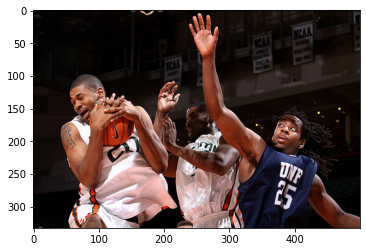

Greedy Search: a basketball player in a white uniform is running with a ball in his hand
Beam Search, K = 3: a group of men play basketball
Beam Search, K = 5: a group of men play basketball
Beam Search, K = 7: a group of men play basketball
Beam Search, K = 10: a basketball player tries to catch the ball


In [27]:
pic = '3155451946_c0862c70cb.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

# beam index, increases the processing required to get most^2 likely words

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

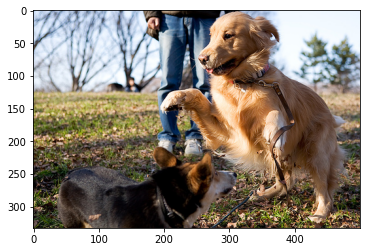

Greedy: two dogs are running through the grass
Beam Search, K = 3: two brown and white dogs running on grass
Beam Search, K = 5: two brown and white dogs run through the grass
Beam Search, K = 7: two brown and white dogs run through the grass
Beam Search, K = 10: two brown and white dogs look at each other in the grass


In [28]:
pic = list(encoding_test.keys())[9]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))